# Cats-vs-Dogs - image dataset for binary classification

![CatsVsDogs](Cats-Dogs-Classification-deep-learning.gif)

## Import of necessary libraries

In [255]:
# General purpose packages
import os
import random
import numpy as np
import pandas as pd
from shutil import copyfile

# Visualization data
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import seaborn as sns
import visualkeras

# Keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Data processing

Let's check the distrubution of the data.


In [281]:
# List of image names for Cats and Dogs
dog_list = os.listdir("PetImages/Dog")
cat_list = os.listdir("PetImages/Cat")

# List of labels for Cats and Dogs
list1_labels = ['Cat'] * len(cat_list)
list2_labels = ['Dog'] * len(dog_list)

# We combine both lists and their corresponding labels
combined_list = cat_list + dog_list
combined_labels = list1_labels + list2_labels

# Create the DataFrame
data = {
    'Filename': combined_list,
    'Animal': combined_labels
}
df = pd.DataFrame(data)

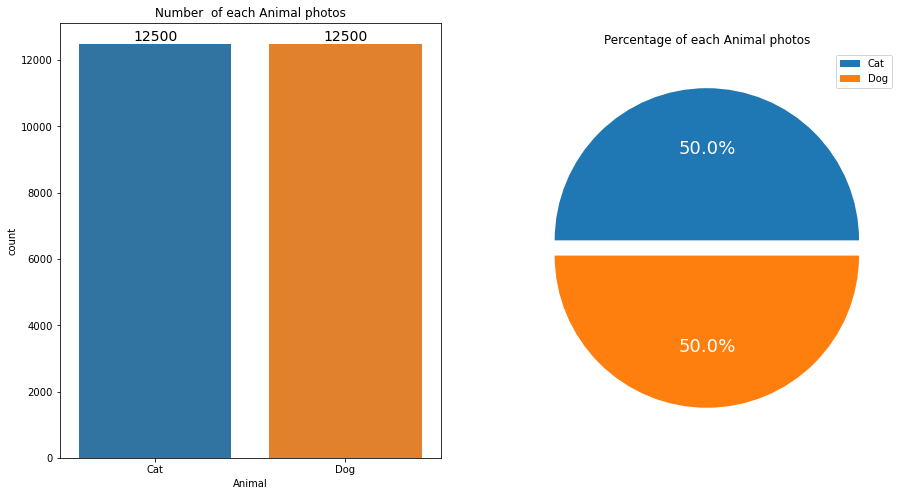

In [283]:
fig, axes = plt.subplots(figsize=(15,8), ncols=2)

ax = axes[0]
sns.countplot(x=df['Animal'], data=df, ax=axes[0])
ax.set_title('Number  of each Animal photos')
ax.bar_label(ax.containers[0], fontsize=14);

ax = axes[1]
plt.pie(df['Animal'].value_counts(), labels=df['Animal'].unique(), autopct='%0.1f%%', explode=(0, 0.1), textprops={'fontsize': 18, 'color': "w"})
ax.set_title('Percentage of each Animal photos')
ax.legend(['Cat', 'Dog'])

plt.show()

In [284]:
del df
del data

Great the data is perfectly balanced

**Create directories for training and validation**

In [5]:
# Example usage
dirs_structure = {
    'cats-v-dogs': {
        'training': {
            'cat': [],
            'dog': [],
        },
        'validation': {
            'cat': [],
            'dog': [],
        },
        'test': {
            'cat': [],
            'dog': [],
        }
    }
}

base_dir = ''

In [9]:
def create_dirs(base_dir, dirs_structure):
    """
    Recursively create nested directories based on a nested structure.

    Parameters:
    base_dir (str): The base directory to start creating nested directories.
    nested_dirs (list or dict): Nested structure defining the directory hierarchy.
    """
    if isinstance(dirs_structure, list):
        for dir_name in dirs_structure:
            sub_dir_path = os.path.join(base_dir, dir_name)
            if not os.path.exists(sub_dir_path):
                os.makedirs(sub_dir_path)
                print(f"Directory '{sub_dir_path}' created.")
            else:
                print(f"Directory '{sub_dir_path}' already exists.")
    elif isinstance(dirs_structure, dict):
        for dir_name, sub_dirs in dirs_structure.items():
            sub_dir_path = os.path.join(base_dir, dir_name)
            if not os.path.exists(sub_dir_path):
                os.makedirs(sub_dir_path)
                print(f"Directory '{sub_dir_path}' created.")
            else:
                print(f"Directory '{sub_dir_path}' already exists.")
            create_dirs(sub_dir_path, sub_dirs)
            
# Create the directories
create_dirs(base_dir, dirs_structure)     

Directory 'cats-v-dogs' created.
Directory 'cats-v-dogs\training' created.
Directory 'cats-v-dogs\training\cat' created.
Directory 'cats-v-dogs\training\dog' created.
Directory 'cats-v-dogs\validation' created.
Directory 'cats-v-dogs\validation\cat' created.
Directory 'cats-v-dogs\validation\dog' created.
Directory 'cats-v-dogs\test' created.
Directory 'cats-v-dogs\test\cat' created.
Directory 'cats-v-dogs\test\dog' created.


In [10]:
def count_items_in_dirs(base_dir, dirs_structure):
    """
    Recursively count and print the number of items in each directory
    based on a nested structure.

    Parameters:
    base_dir (str): The base directory to start counting items in.
    nested_dirs (list or dict): Nested structure defining the directory hierarchy.
    """
    if isinstance(dirs_structure, list):
        for dir_name in dirs_structure:
            sub_dir_path = os.path.join(base_dir, dir_name)
            items_count = len(os.listdir(sub_dir_path))
            print(f"Number of items in directory '{sub_dir_path}': {items_count}")
    elif isinstance(dirs_structure, dict):
        for dir_name, sub_dirs in dirs_structure.items():
            sub_dir_path = os.path.join(base_dir, dir_name)
            items_count = len(os.listdir(sub_dir_path))
            print(f"Number of items in directory '{sub_dir_path}': {items_count}")
            count_items_in_dirs(sub_dir_path, sub_dirs)

# Count the items in each directory
count_items_in_dirs(base_dir, dirs_structure)

Number of items in directory 'cats-v-dogs': 3
Number of items in directory 'cats-v-dogs\training': 2
Number of items in directory 'cats-v-dogs\training\cat': 0
Number of items in directory 'cats-v-dogs\training\dog': 0
Number of items in directory 'cats-v-dogs\validation': 2
Number of items in directory 'cats-v-dogs\validation\cat': 0
Number of items in directory 'cats-v-dogs\validation\dog': 0
Number of items in directory 'cats-v-dogs\test': 2
Number of items in directory 'cats-v-dogs\test\cat': 0
Number of items in directory 'cats-v-dogs\test\dog': 0


**Now let's create a function to split the data.**

In [11]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.8):
    """
    Splits the data into train, validation, and test sets (optional).

    Args:
    main_dir (string): Path containing the images.
    training_dir (string): Path to be used for training.
    validation_dir (string): Path to be used for validation.
    test_dir (string): Path to be used for test.
    include_test_split (bool): Whether to include a test split or not.
    split_size (float): Size of the dataset to be used for training.
    """
    files = [file for file in os.listdir(main_dir) if os.path.getsize(os.path.join(main_dir, file))]

    shuffled_files = random.sample(files, len(files))  # shuffles the data
    split = int(split_size * len(shuffled_files))  # training split casted into int for numeric rounding
    train = shuffled_files[:split]  # training split
    split_valid_test = int(split + (len(shuffled_files) - split) / 2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test]  # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element))  # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir, element), os.path.join(validation_dir, element))  # copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir, element), os.path.join(test_dir, element))  # copy files into test directory

    print("Split successful!")


main_dir_cat = 'PetImages/Cat'  # specify the path to the main directory containing images
main_dir_dog = 'PetImages/Dog'  # specify the path to the main directory containing images


# Generate the directory paths based on the nested structure
training_dir_cat = os.path.join(base_dir, 'cats-v-dogs', 'training', 'cat')
validation_dir_cat = os.path.join(base_dir, 'cats-v-dogs', 'validation', 'cat')
test_dir_cat = os.path.join(base_dir, 'cats-v-dogs', 'test', 'cat')
training_dir_dog = os.path.join(base_dir, 'cats-v-dogs', 'training', 'dog')
validation_dir_dog = os.path.join(base_dir, 'cats-v-dogs', 'validation', 'dog')
test_dir_dog = os.path.join(base_dir, 'cats-v-dogs', 'test', 'dog')

# Split the data
split_data(main_dir_cat, training_dir_cat, validation_dir_cat, test_dir_cat, include_test_split=True, split_size=0.8)
split_data(main_dir_dog, training_dir_dog, validation_dir_dog, test_dir_dog, include_test_split=True, split_size=0.8)

# Count the items in each directory
count_items_in_dirs(base_dir, dirs_structure)

Split successful!
Split successful!
Number of items in directory 'cats-v-dogs': 3
Number of items in directory 'cats-v-dogs\training': 2
Number of items in directory 'cats-v-dogs\training\cat': 9999
Number of items in directory 'cats-v-dogs\training\dog': 9999
Number of items in directory 'cats-v-dogs\validation': 2
Number of items in directory 'cats-v-dogs\validation\cat': 1250
Number of items in directory 'cats-v-dogs\validation\dog': 1250
Number of items in directory 'cats-v-dogs\test': 2
Number of items in directory 'cats-v-dogs\test\cat': 1250
Number of items in directory 'cats-v-dogs\test\dog': 1250


## Create Generators

Create generators for our model.

In [81]:
# Parameters of our images
image_size = 150
image_channel = 3
bat_size = 32

In [128]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

The shuffle parameter determines whether the data should be randomly shuffled before being fed into the model.

1. Training the model (shuffle=True):
    - Randomly shuffling the training data helps the model generalize better and prevents overfitting. It ensures that the model learns general patterns rather than the sequence in the data.


2. Validating and testing the model (shuffle=False):
    - Typically, you want the validation and test data to be in the same order to consistently evaluate the model. Not shuffling ensures that validation results are repeatable.

In [440]:
train_generator = train_datagen.flow_from_directory(
    'cats-v-dogs/training',
    target_size=(image_size, image_size),
    batch_size=bat_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'cats-v-dogs/validation',
    target_size=(image_size, image_size),
    batch_size=bat_size,
    shuffle=False,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'cats-v-dogs/test',
    target_size=(image_size, image_size),
    batch_size=bat_size,
    shuffle=False,
    class_mode='categorical')

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Visualize images from generators

**Now let's make sure we got the correct data**

Displaying 10 sample images from cats-v-dogs/training:


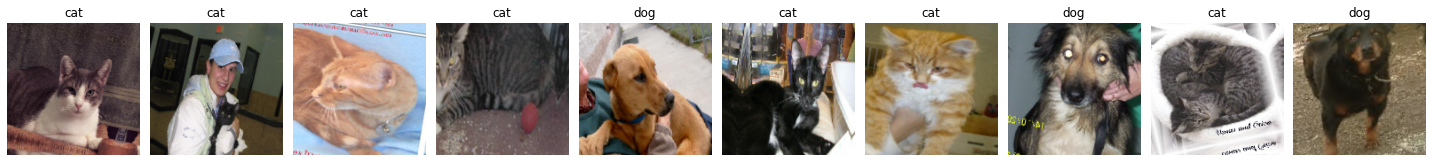

----------------------------------------------------------

Displaying 10 sample images from cats-v-dogs/validation:


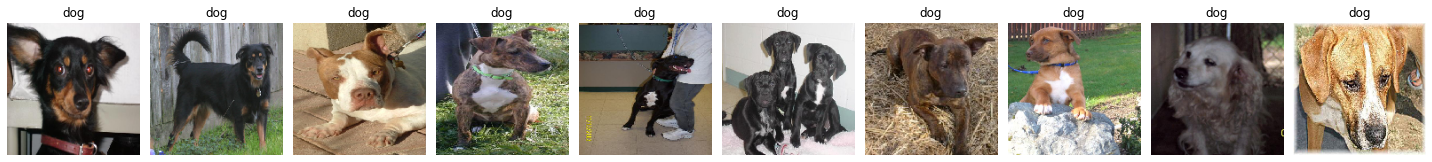

----------------------------------------------------------

Displaying 10 sample images from cats-v-dogs/test:


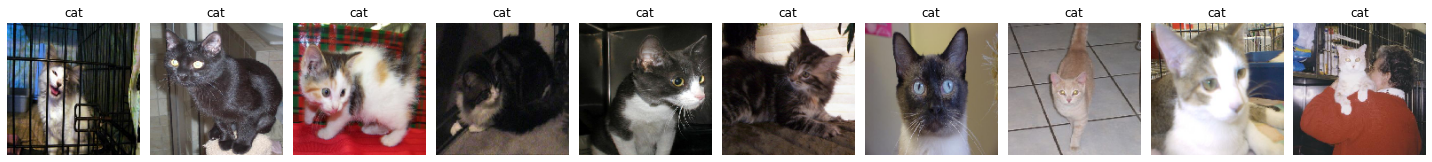

----------------------------------------------------------



In [365]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_from_generator(generator, n_images):
    """
    Function to display sample images from a given generator with actual class labels.

    Parameters:
    generator (DirectoryIterator): The generator object from which images will be displayed.
    n_images (int): The number of images to display.
    """
    # Ensure n_images does not exceed batch size
    n_images = min(n_images, generator.batch_size)

    # Display sample images from the generator with actual class labels
    print(f"Displaying {n_images} sample images from {generator.directory}:")

    fig, axes = plt.subplots(1, n_images, figsize=(20, 5))
    axes = axes.ravel()

    class_mapping = {v: k for k, v in generator.class_indices.items()}  # Invert class_indices mapping
    
    images, labels = generator.next() # Images and labels in the batch

    for i in range(n_images):
        image = images[i]
        class_index = np.argmax(labels[i])  # Assuming labels are one-hot encoded
        class_label = class_mapping[class_index]
        axes[i].imshow(image)
        axes[i].set_title(f"{class_label}")
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    print('----------------------------------------------------------\n')

# Example usage with train_generator
show_images_from_generator(train_generator, 10)
show_images_from_generator(validation_generator, 10)
show_images_from_generator(test_generator, 10)


## Model CNN

Architecture

The architecture of the Cat vs Dog Image Classification model consists of the following Layers and components:

Layers :
- The input layer consist of a Conv2D with 32 filters and activation relu.
- The model contain the 3 blocks of convolution with increasing filters and activation relu.
- Each convolution block contains Batch Noramlization, Max pooling (pool_size = 2) and Dropout (0.2).
- The fully connected layers contain Flatten layer, Dense layer with 512 units and a Dropout layer.
- The output layer is a Dense layer with 2 units and softmax activation.

Components:
- Input Layer: Receives input images for classification.
- Convolutional Layers: Extract features from the images through convolutional operations.
- Pooling Layers: Reduce the spatial dimensions of the feature maps.
- Flatten Layer: Convert the 2D feature maps into a 1D vector.
- Fully Connected Layers: Perform classification using densely connected layers.
- Output Layer: Provides the final prediction probabilities for cat and dog classes.

### Definition od CNN model

In [130]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3), activation='relu', input_shape = (image_size, image_size, image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax')) #sigmoid

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_39 (Bat  (None, 148, 148, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_40 (Bat  (None, 72, 72, 64)     

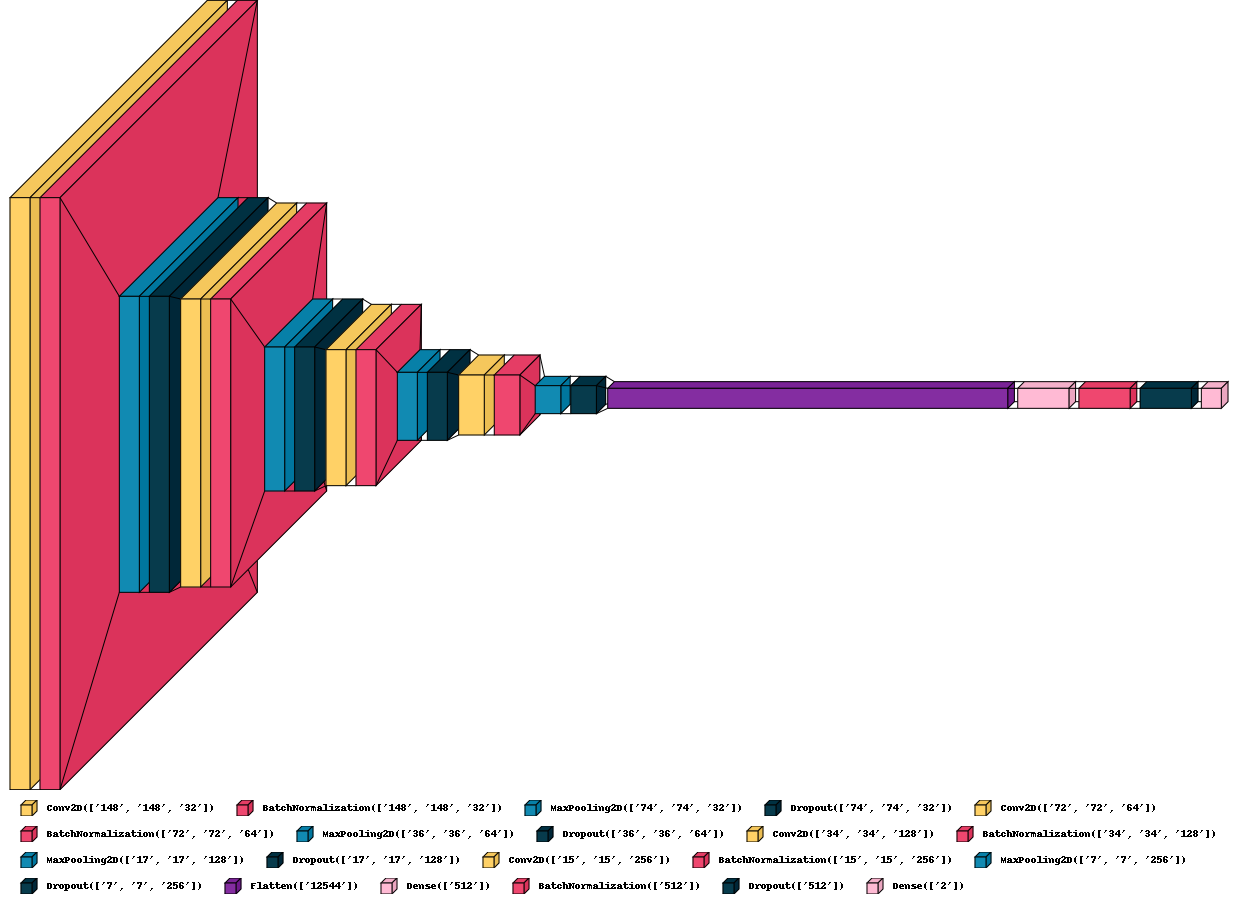

In [131]:
visualkeras.layered_view(model, legend=True, show_dimension=True)

### Callbacks

We will be using two callbacks -
1. ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.
2. EarlyStopping : Stop training when a monitored metric has stopped improving.

In [132]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=10,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',
                              patience= 10,
                              restore_best_weights=True,
                              verbose=0)

### Compile the model

Finally we will compile the model .There are 3 things to mention here : Optimizer,Loss, Metrics
- Optimizer :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.​
- Loss :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.​
- Metrics :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [133]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Fit the model

We are now going to train our compiled model using the train iterator (train_generator) and use the val iterator (val_generator) as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).

The model will be fit for 30 epochs.

In [134]:
cat_dog = model.fit(train_generator,
                    validation_data = validation_generator, 
                    callbacks=[early_stoping, learning_rate_reduction],
                    epochs = 30,
                   )

Epoch 1/30
531/625 [========================>.....] - ETA: 2:07 - loss: 0.6667 - accuracy: 0.6583

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 855s 1s/step - loss: 0.6520 - accuracy: 0.6670 - val_loss: 0.5643 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 731s 1s/step - loss: 0.5096 - accuracy: 0.7509 - val_loss: 0.4351 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 738s 1s/step - loss: 0.4185 - accuracy: 0.8088 - val_loss: 0.4603 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 740s 1s/step - loss: 0.3668 - accuracy: 0.8381 - val_loss: 0.3318 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 747s 1s/step - loss: 0.3294 - accuracy: 0.8546 - val_loss: 0.7777 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 746s 1s/step - loss: 0.3004 - accuracy: 0.8723 - val_loss: 0.3309 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 740s 1s/step - loss: 

### Save Model

In [458]:
model.save('model\model.h5')

In [459]:
model.save_weights(r"model\model_weights.h5")

### Virtualize Training

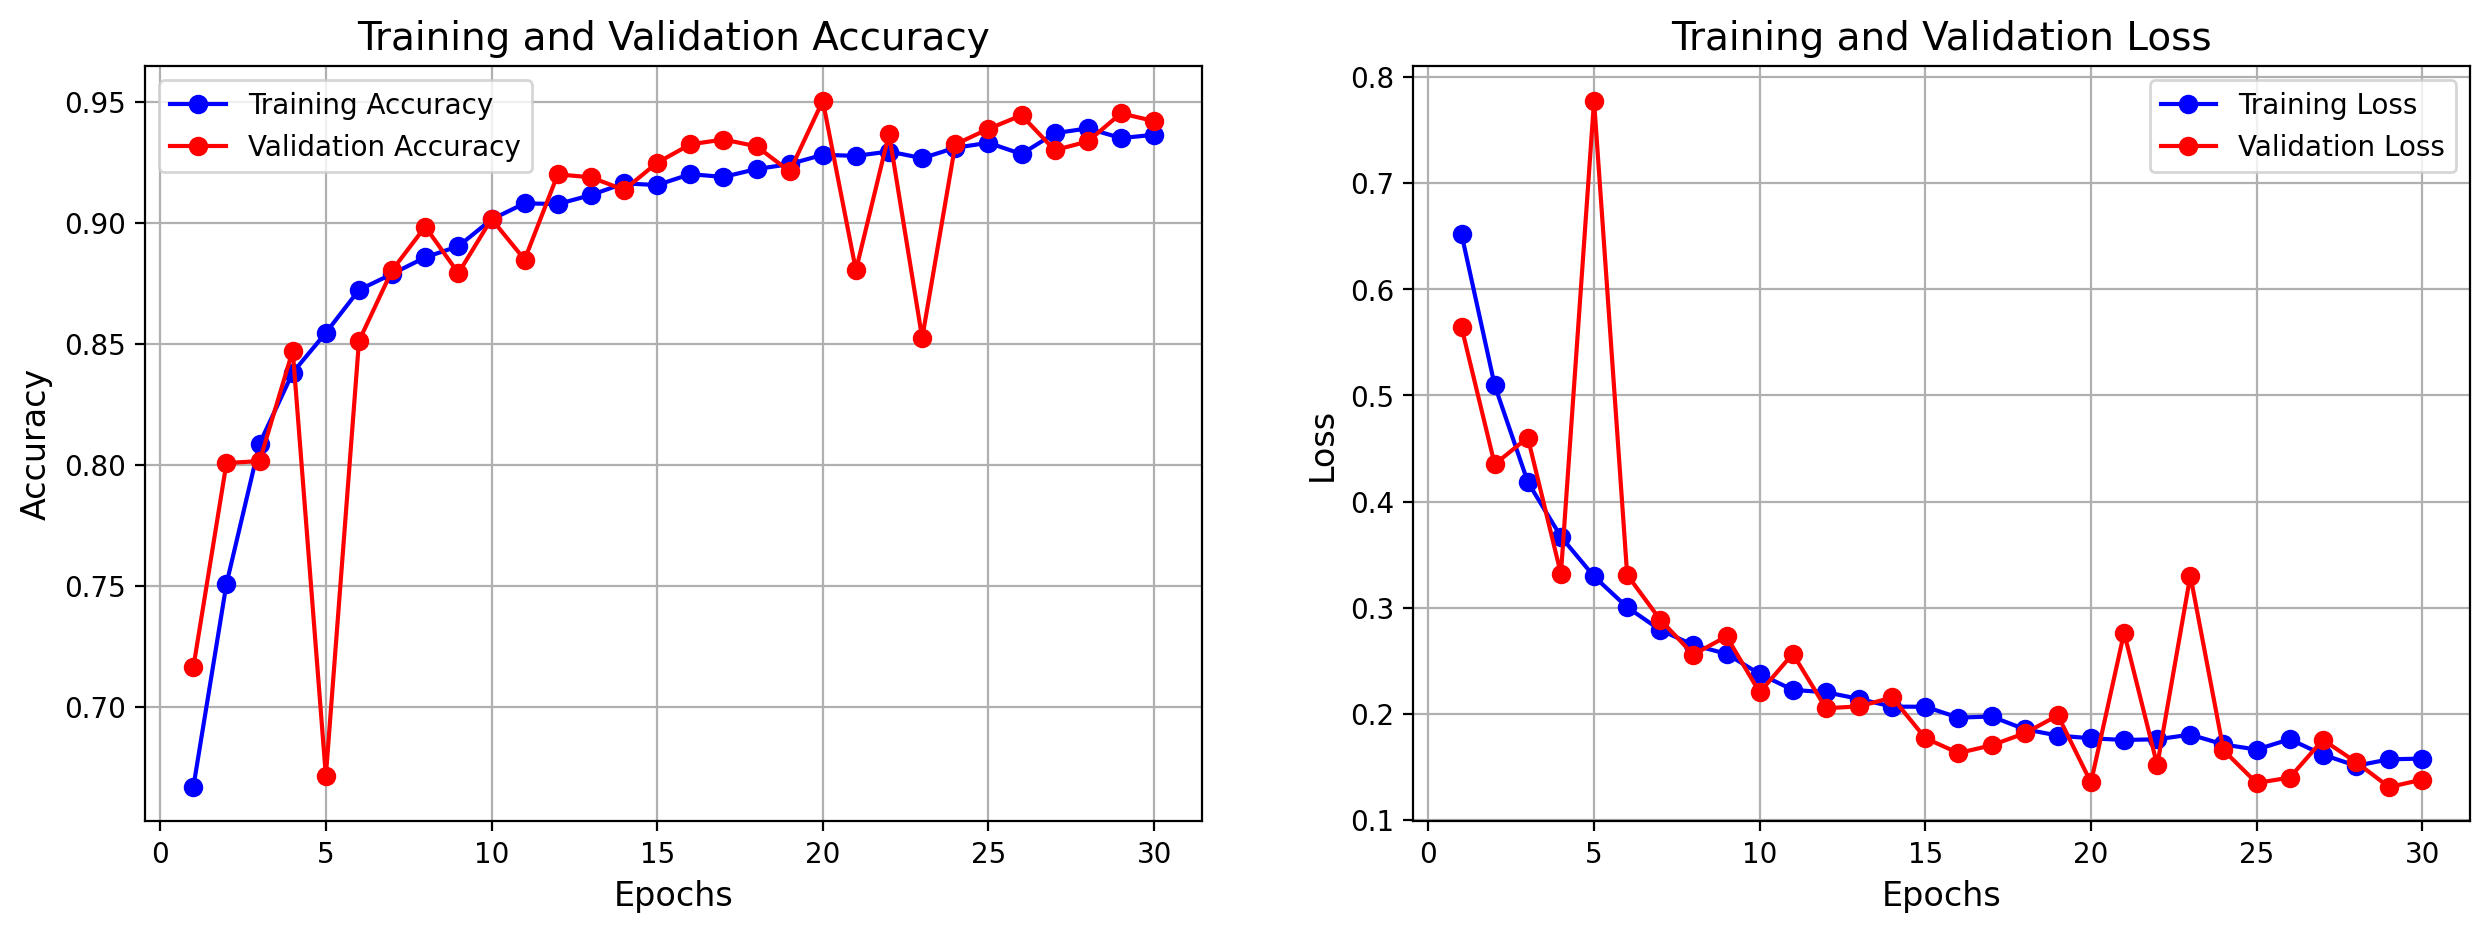

In [136]:
# Extracting history
lstm_train_acc = cat_dog.history['accuracy']
lstm_val_acc = cat_dog.history['val_accuracy']

# Extracting history
lstm_train_loss = cat_dog.history['loss']
lstm_val_loss = cat_dog.history['val_loss']

# Creating epochs range
epochs = range(1, len(lstm_train_acc) + 1)

# Visualization of Training and Validation Accuracies
plt.figure(figsize=(15,5), dpi=200)

plt.subplot(121)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.plot(epochs, lstm_train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, lstm_val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.title('Training and Validation Loss', fontsize=14)
plt.plot(epochs, lstm_train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, lstm_val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

In [137]:
# Evaluvate for train generator
loss, acc = model.evaluate(train_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:', acc*100)
print('The Loss of the model for training data is:', loss)

# Evaluvate for validation generator
loss, acc = model.evaluate(validation_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:', acc*100)
print('The Loss of the model for validation data is:', loss)

The accuracy of the model for training data is: 94.55445408821106
The Loss of the model for training data is: 0.13807256519794464
The accuracy of the model for validation data is: 94.19999718666077
The Loss of the model for validation data is: 0.13797155022621155


### Prediction

Now, we will predict the model on test dataset.

In [138]:
# Prediction
result = model.predict(test_generator, batch_size=bat_size, verbose=0)
y_pred = np.argmax(result, axis = 1)
y_true = test_generator.labels

# Evaluvate
loss, acc = model.evaluate(test_generator, batch_size=bat_size, verbose=0)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 93.91999840736389
The Loss of the model for testing data is: 0.15114212036132812


### Classification report

In [139]:
print('\tClassification Report:\n\n', classification_report(y_true, y_pred, target_names=['Cat','Dog']))

	Classification Report:

               precision    recall  f1-score   support

         Cat       0.96      0.92      0.94      1250
         Dog       0.92      0.96      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



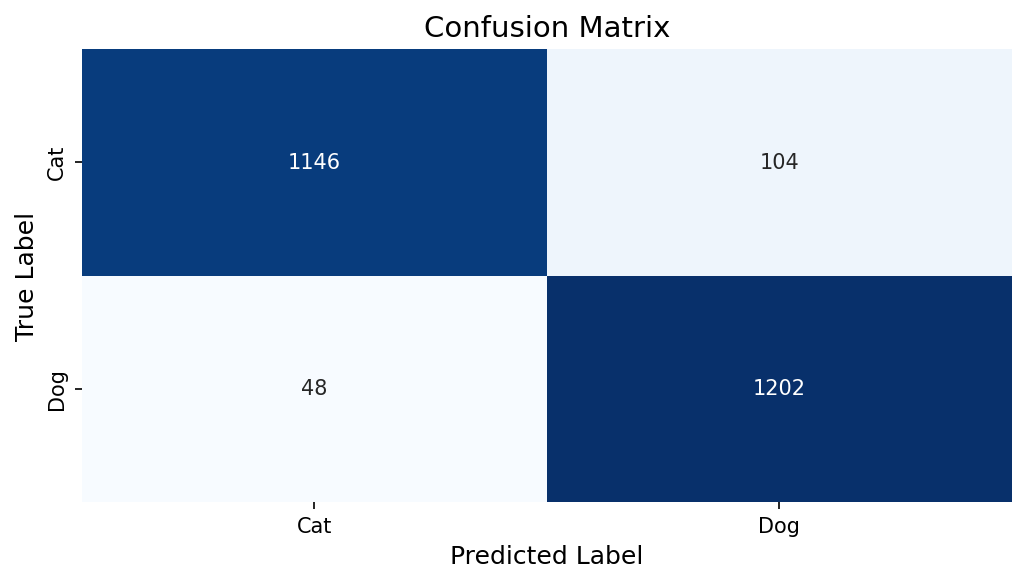

In [279]:
fig, axes = plt.subplots(figsize =(8,4), dpi=150)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues", fmt='.0f', ax=axes, cbar=False, xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.show()

## Results

In [285]:
def filenames(path, animal_prefix):
    """
    Create a list of image names in the specified path and change these names by adding a prefix.

    Parameters:
    path (str): Path to images.
    animal (str): Animal prefix ('cat_' or 'dog_').
    """
    results = []
    complete_path = []
    name_list = os.listdir(path)
    for element in name_list:
        names = str(animal_prefix) + str(element)
        results.append(names)
        
        element_path = os.path.join(path, element)
        complete_path.append(element_path)
    return results, complete_path

In [286]:
# Image names with prefix
list_cat_filenames = filenames(test_dir_cat, 'cat_')
list_dog_filenames = filenames(test_dir_dog, 'dog_')

In [287]:
# List of labels for Cats and Dogs
list_cat_labels = ['Cat'] * len(os.listdir(test_dir_cat))
list_dog_labels = ['Dog'] * len(os.listdir(test_dir_dog))

# We combine both lists and their corresponding labels and paths
combined_filenames = list_cat_filenames[0] + list_dog_filenames[0]
combined_labels = list_cat_labels + list_dog_labels
combined_paths = list_cat_filenames[1] + list_dog_filenames[1]

# Create the DataFrame
data = {
    'Filename': combined_filenames,
    'Label': combined_labels,
    'Prediction': 'None',
    'Path': combined_paths
}

df_test = pd.DataFrame(data)
df_test

,Filename,Label,Prediction,Path
0,cat_10002.jpg,Cat,None,cats-v-dogs\test\cat\10002.jpg
1,cat_10021.jpg,Cat,None,cats-v-dogs\test\cat\10021.jpg
2,cat_10025.jpg,Cat,None,cats-v-dogs\test\cat\10025.jpg
3,cat_10037.jpg,Cat,None,cats-v-dogs\test\cat\10037.jpg
4,cat_10068.jpg,Cat,None,cats-v-dogs\test\cat\10068.jpg
...,...,...,...,...
2495,dog_9919.jpg,Dog,None,cats-v-dogs\test\dog\9919.jpg
2496,dog_9931.jpg,Dog,None,cats-v-dogs\test\dog\9931.jpg
2497,dog_9946.jpg,Dog,None,cats-v-dogs\test\dog\9946.jpg
2498,dog_9980.jpg,Dog,None,cats-v-dogs\test\dog\9980.jpg


In [288]:
# Prediction
result = model.predict(test_generator, batch_size=bat_size, verbose=0)
y_pred = np.argmax(result, axis = 1)

df_test['Prediction'] = y_pred

# Mapping
label_mapping = {0: 'Cat', 1: 'Dog'}
df_test['Prediction'] = df_test['Prediction'].map(label_mapping)
df_test.head()

,Filename,Label,Prediction,Path
0,cat_10002.jpg,Cat,Cat,cats-v-dogs\test\cat\10002.jpg
1,cat_10021.jpg,Cat,Cat,cats-v-dogs\test\cat\10021.jpg
2,cat_10025.jpg,Cat,Cat,cats-v-dogs\test\cat\10025.jpg
3,cat_10037.jpg,Cat,Dog,cats-v-dogs\test\cat\10037.jpg
4,cat_10068.jpg,Cat,Cat,cats-v-dogs\test\cat\10068.jpg


### CSV file output

In [289]:
df_test.to_csv('Prediction_results.csv', index=True)

## Visualize classified images

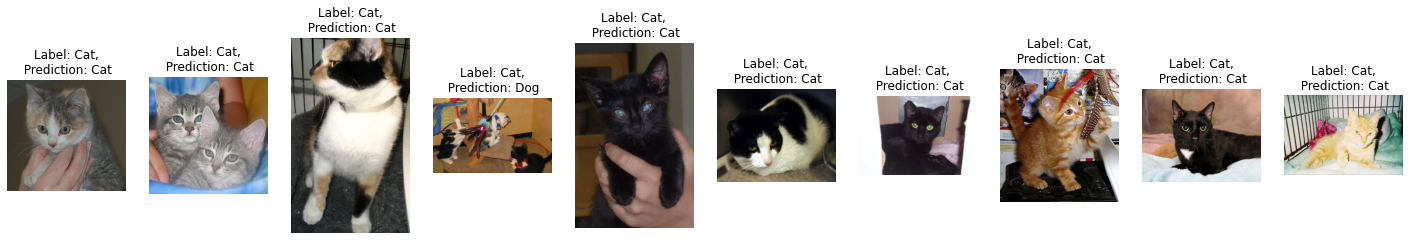

In [290]:
fig, axes = plt.subplots(1, 10, figsize=(25, 8))

for idx in range(10):
    image_path = df_test.iloc[idx]['Path']
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {df_test.iloc[idx]['Label']},\n Prediction: {df_test.iloc[idx]['Prediction']}")
    axes[idx].axis('off')
    
plt.show()

After watching the images we can see the our model is quite accurate with 94% accuracy.

## Conclusion

We successfully built a deep neural network model by implementing Convolutional Neural Network (CNN) to classify dog and cat images with very high accuracy about 94%.

The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.

The Cat vs Dog Image Classification model demonstrates the successful implementation of a Convolutional Neural Network for image classification tasks. By accurately distinguishing between images of cats and dogs, this project showcases the potential of deep learning algorithms in solving real-world problems involving image analysis.

## My photos - Are Jętek and Krówka cats? Is Odi the dog?

In [489]:
# loading into dataframe
test_dir_my_photos = "TEST"

filenames= os.listdir(test_dir_my_photos)

test_data_my_photos = pd.DataFrame({"Filename": filenames})
test_data_my_photos['Prediction'] = 'None'

test_data_my_photos

,Filename,Prediction
0,Jetek.jpg,None
1,Krowka.jpg,None
2,Odi.jpg,None


In [490]:
# Create data genenerator for test data

test_generator_my_photos = test_datagen.flow_from_directory(
    'My_photos',
    target_size=(image_size, image_size),
    batch_size=2,
    shuffle=False,
    class_mode='categorical')


# Test Prediction
my_photos_predict = model.predict(test_generator_my_photos, verbose = 0)

y_test_pred_my_photos = np.argmax(my_photos_predict, axis=1)

test_data_my_photos['Prediction'] = y_test_pred_my_photos

# mapping
label_mapping = {0: 'Cat', 1: 'Dog'}
test_data_my_photos['Prediction'] = test_data_my_photos['Prediction'].map(label_mapping)
test_data_my_photos


Found 3 images belonging to 2 classes.


,Filename,Prediction
0,Jetek.jpg,Cat
1,Krowka.jpg,Cat
2,Odi.jpg,Dog


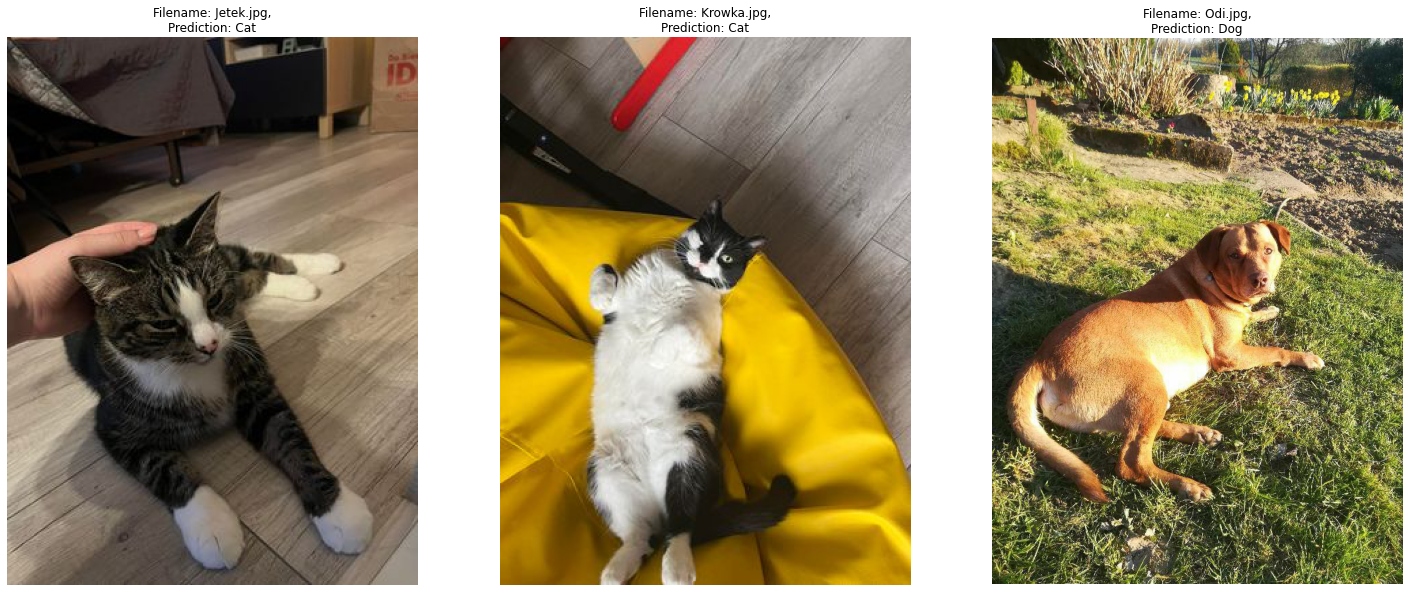

In [499]:
fig, axes = plt.subplots(1, 3, figsize=(25,15))

for idx in range(3):
#     image_path = test_data_wieliczka.iloc[idx]['Path']
    image_path = os.path.join(test_dir_my_photos, test_data_my_photos.iloc[idx]['Filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title(f"Filename: {test_data_my_photos.iloc[idx]['Filename']},\nPrediction: {test_data_my_photos.iloc[idx]['Prediction']}")
    axes[idx].axis('off')
    
plt.show()